In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import argparse
import sys
import os
from pathlib import Path

In [145]:
def plot_roc_curve(ax, OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos):
    # read results
    df_oup_neg = pd.read_csv(OUP_neg, sep="\t")
    df_oup_pos = pd.read_csv(OUP_pos, sep="\t")
    df_egx_neg = pd.read_csv(EGX_neg, sep=",")
    df_egx_pos = pd.read_csv(EGX_pos, sep=",")
    df_dea_neg = pd.read_csv(DEA_neg, sep="\t")
    df_dea_pos = pd.read_csv(DEA_pos, sep="\t")
    
    # ground truth
    n_neg = len(df_oup_neg)
    n_pos = len(df_oup_pos)
    truth = np.array([False]*n_neg + [True]*n_pos)
    
    # OUP
    result_oup_neg = np.sign(df_oup_neg["h1_theta1"].values - df_oup_neg["h1_theta0"].values) * (-np.log10(df_oup_neg["p"].values))
    result_oup_pos = np.sign(df_oup_pos["h1_theta1"].values - df_oup_pos["h1_theta0"].values) * (-np.log10(df_oup_pos["p"].values))
    p_oup = np.concatenate((result_oup_neg, result_oup_pos))
    fpr1, tpr1, _ = roc_curve(truth, p_oup)
    roc_auc1 = auc(fpr1, tpr1)
    
    # EGX
    result_egx_neg = np.sign(df_egx_neg["ou2_theta"].iloc[1::2].values - df_egx_neg["ou2_theta"].iloc[::2].values) * (-np.log10(df_egx_neg["ou2_vs_ou1_pvalue"].iloc[::2].values))
    result_egx_pos = np.sign(df_egx_pos["ou2_theta"].iloc[1::2].values - df_egx_pos["ou2_theta"].iloc[::2].values) * (-np.log10(np.maximum(1e-100, df_egx_pos["ou2_vs_ou1_pvalue"].iloc[::2].values)))
    p_egx = np.concatenate((result_egx_neg, result_egx_pos))
    fpr2, tpr2, _ = roc_curve(truth, p_egx)
    roc_auc2 = auc(fpr2, tpr2)
    
    # DEA
    result_dea_neg = np.sign(df_dea_neg["log2FC"].values) * (-np.log10(df_dea_neg["p_value"].values))
    result_dea_pos = np.sign(df_dea_pos["log2FC"].values) * (-np.log10(df_dea_pos["p_value"].values))
    p_dea = np.concatenate((result_dea_neg, result_dea_pos))
    fpr3, tpr3, _ = roc_curve(truth, p_dea)
    roc_auc3 = auc(fpr3, tpr3)
    
    # plot ROC
    ax.plot(fpr3, tpr3, lw=1.5, color="tab:gray", label=f'DEA {roc_auc2:.3f}')
    ax.plot(fpr2, tpr2, lw=1.5, color="tab:orange", label=f'EGX {roc_auc3:.3f}')
    ax.plot(fpr1, tpr1, lw=1.5, color="tab:green", label=f'OUP {roc_auc1:.3f}')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line for random guessing
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    #ax.set_xlabel('False Positive Rate')
    #ax.set_ylabel('True Positive Rate')
    
    handles, labels = ax.get_legend_handles_labels()
    order = [f'OUP {roc_auc1:.3f}', f'EGX {roc_auc3:.3f}', f'DEA {roc_auc2:.3f}']  # for example
    ordered_handles = [handles[labels.index(o)] for o in order]
    ordered_labels = [o for o in order]
    ax.legend(ordered_handles, ordered_labels, frameon=False, loc='lower right')

alpha 3, sigma 1


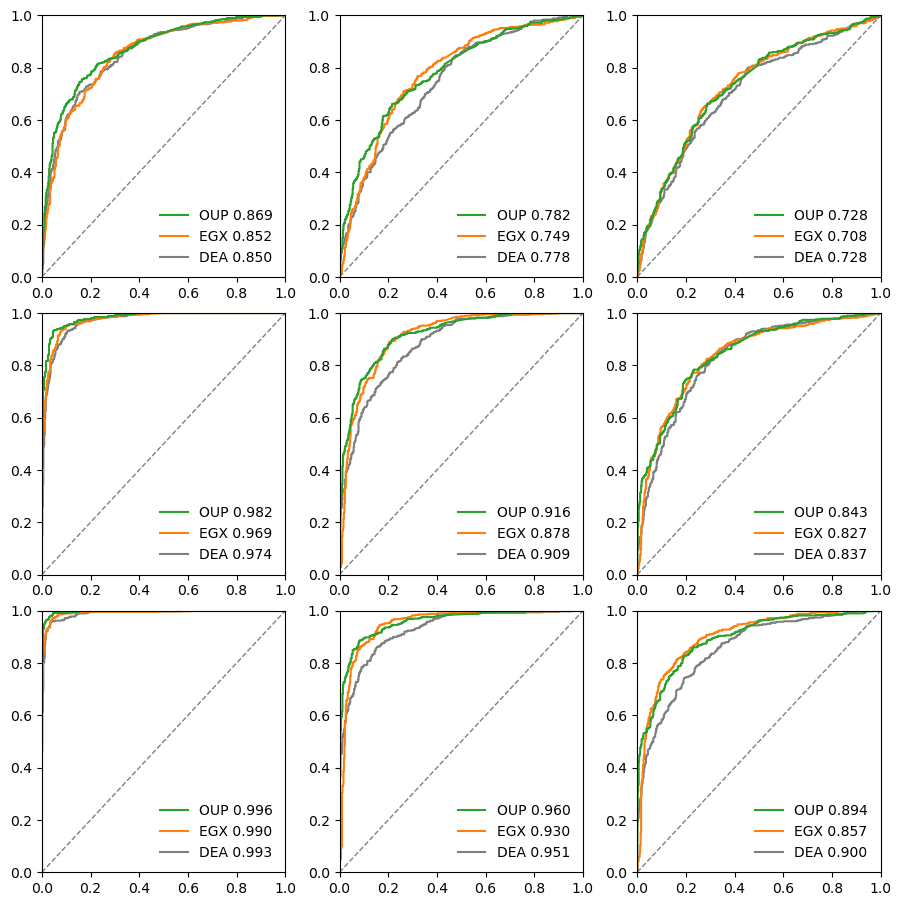

In [ ]:
rs = [0.5, 0.2, 0.1]
thetas = [1, 2, 3]

for a in [3]:
    for s in [1]:
        print(f"alpha {a}, sigma {s}")
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        for i in range(len(rs)):
            for j in range(len(thetas)):
                OUP_neg = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0_chi-squared.tsv"
                OUP_pos = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0-{thetas[j]}_chi-squared.tsv"
                DEA_neg = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0.tsv"
                DEA_pos = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0-{thetas[j]}.tsv"
                EGX_neg = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0_long.csv"
                EGX_pos = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0-{thetas[j]}_long.csv"
                plot_roc_curve(axes[j, i], OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos)
        plt.tight_layout(pad=0.5)
        plt.savefig(f"./a{a}_s{s}_ROC.png", dpi=300, bbox_inches="tight")
        plt.show(fig)

In [117]:
def plot_prc_curve(ax, OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos):
    # read results
    df_oup_neg = pd.read_csv(OUP_neg, sep="\t")
    df_oup_pos = pd.read_csv(OUP_pos, sep="\t")
    df_egx_neg = pd.read_csv(EGX_neg, sep=",")
    df_egx_pos = pd.read_csv(EGX_pos, sep=",")
    df_dea_neg = pd.read_csv(DEA_neg, sep="\t")
    df_dea_pos = pd.read_csv(DEA_pos, sep="\t")
    
    # ground truth
    n_neg = len(df_oup_neg)
    n_pos = len(df_oup_pos)
    truth = np.array([False]*n_neg + [True]*n_pos)
    
    # OUP
    result_oup_neg = np.sign(df_oup_neg["h1_theta1"].values - df_oup_neg["h1_theta0"].values) * (-np.log10(df_oup_neg["p"].values))
    result_oup_pos = np.sign(df_oup_pos["h1_theta1"].values - df_oup_pos["h1_theta0"].values) * (-np.log10(df_oup_pos["p"].values))
    p_oup = np.concatenate((result_oup_neg, result_oup_pos))
    precision1, recall1, _ = precision_recall_curve(truth, p_oup)
    prc_auc1 = average_precision_score(truth, p_oup)

    # EGX
    result_egx_neg = np.sign(df_egx_neg["ou2_theta"].iloc[1::2].values - df_egx_neg["ou2_theta"].iloc[::2].values) * (-np.log10(df_egx_neg["ou2_vs_ou1_pvalue"].iloc[::2].values))
    result_egx_pos = np.sign(df_egx_pos["ou2_theta"].iloc[1::2].values - df_egx_pos["ou2_theta"].iloc[::2].values) * (-np.log10(np.maximum(1e-100, df_egx_pos["ou2_vs_ou1_pvalue"].iloc[::2].values)))
    p_egx = np.concatenate((result_egx_neg, result_egx_pos))
    precision2, recall2, _ = precision_recall_curve(truth, p_egx)
    prc_auc2 = average_precision_score(truth, p_egx)
    
    # DEA
    result_dea_neg = np.sign(df_dea_neg["log2FC"].values) * (-np.log10(df_dea_neg["p_value"].values))
    result_dea_pos = np.sign(df_dea_pos["log2FC"].values) * (-np.log10(df_dea_pos["p_value"].values))
    p_dea = np.concatenate((result_dea_neg, result_dea_pos))
    precision3, recall3, _ = precision_recall_curve(truth, p_dea)
    prc_auc3 = average_precision_score(truth, p_dea)
    
    # plot ROC
    ax.plot(recall3, precision3, lw=1.5, color="tab:gray", label=f'DEA {prc_auc2:.3f}')
    ax.plot(recall2, precision2, lw=1.5, color="tab:orange", label=f'EGX {prc_auc3:.3f}')
    ax.plot(recall1, precision1, lw=1.5, color="tab:green", label=f'OUP {prc_auc1:.3f}')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    #ax.set_xlabel('Recall')
    #ax.set_ylabel('Precision')
    
    handles, labels = ax.get_legend_handles_labels()
    order = [f'OUP {prc_auc1:.3f}', f'EGX {prc_auc3:.3f}', f'DEA {prc_auc2:.3f}']  # for example
    ordered_handles = [handles[labels.index(o)] for o in order]
    ordered_labels = [o for o in order]
    ax.legend(ordered_handles, ordered_labels, frameon=False, loc='lower left')

alpha 3, sigma 1


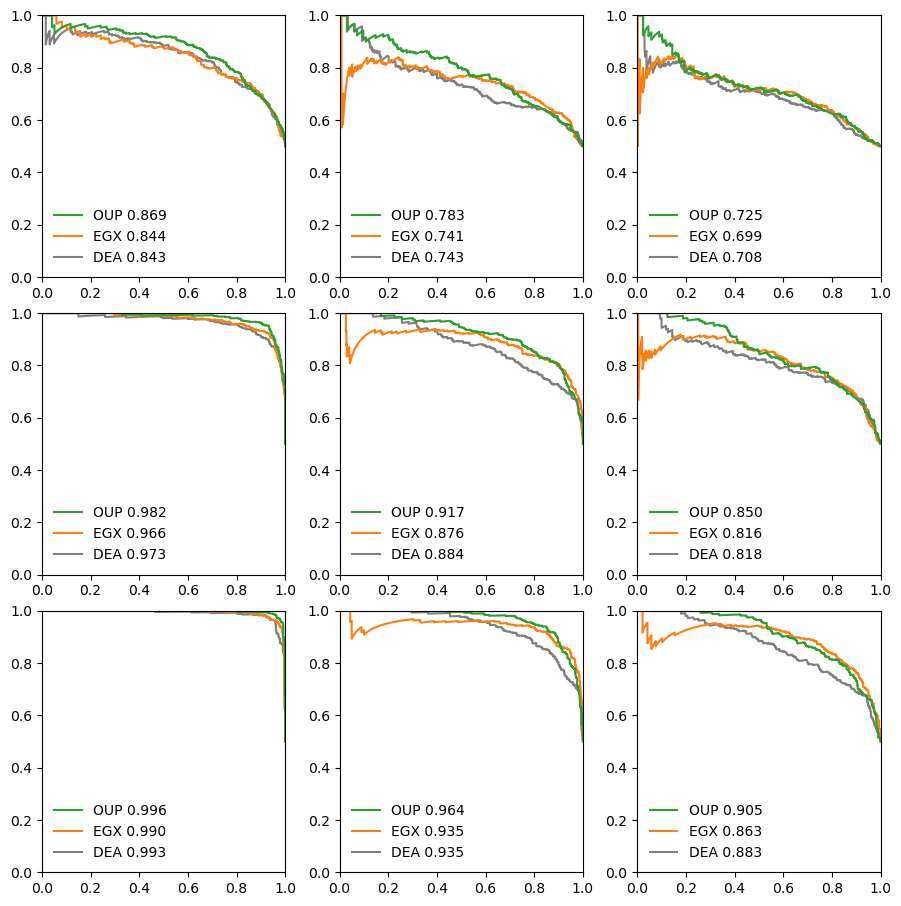

In [ ]:
rs = [0.5, 0.2, 0.1]
thetas = [1, 2, 3]

for a in [3]:
    for s in [1]:
        print(f"alpha {a}, sigma {s}")
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        for i in range(len(rs)):
            for j in range(len(thetas)):
                OUP_neg = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0_chi-squared.tsv"
                OUP_pos = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0-{thetas[j]}_chi-squared.tsv"
                DEA_neg = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0.tsv"
                DEA_pos = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0-{thetas[j]}.tsv"
                EGX_neg = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0_long.csv"
                EGX_pos = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0-{thetas[j]}_long.csv"
                plot_prc_curve(axes[j, i], OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos)
        plt.tight_layout(pad=0.5)
        plt.savefig(f"./a{a}_s{s}_PRC.png", dpi=300, bbox_inches="tight")
        plt.show(fig)

In [2]:
def plot_f1(ax, label, OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos):
    # --- read results ---
    df_oup_neg = pd.read_csv(OUP_neg, sep="\t")
    df_oup_pos = pd.read_csv(OUP_pos, sep="\t")
    df_egx_neg = pd.read_csv(EGX_neg, sep=",")
    df_egx_pos = pd.read_csv(EGX_pos, sep=",")
    df_dea_neg = pd.read_csv(DEA_neg, sep="\t")
    df_dea_pos = pd.read_csv(DEA_pos, sep="\t")
    
    # --- ground truth ---
    n_neg = len(df_oup_neg)
    n_pos = len(df_oup_pos)
    truth = np.array([False]*n_neg + [True]*n_pos)

    # --- OUP predictions (bool) ---
    pred_oup = np.concatenate((
        ((df_oup_neg["h1_theta1"].values > df_oup_neg["h1_theta0"].values) & df_oup_neg["signif"].values.astype(bool)),
        ((df_oup_pos["h1_theta1"].values > df_oup_pos["h1_theta0"].values) & df_oup_pos["signif"].values.astype(bool))
    ))
    precision_oup = precision_score(truth, pred_oup, zero_division=0)
    recall_oup    = recall_score(truth, pred_oup)
    f1_oup        = f1_score(truth, pred_oup)

    # --- DEA predictions (bool) ---
    pred_dea = np.concatenate((
        ((df_dea_neg["log2FC"].values > 0) & df_dea_neg["signif"].values.astype(bool)),
        ((df_dea_pos["log2FC"].values > 0) & df_dea_pos["signif"].values.astype(bool))
    ))
    precision_dea = precision_score(truth, pred_dea, zero_division=0)
    recall_dea    = recall_score(truth, pred_dea)
    f1_dea        = f1_score(truth, pred_dea)

    # --- EGX predictions (bool); pair rows (theta0, theta1), use adaptive flag on the first of each pair ---
    pred_egx = np.concatenate((
        ((df_egx_neg["ou2_theta"].iloc[1::2].values > df_egx_neg["ou2_theta"].iloc[::2].values) &
         df_egx_neg["adaptive"].iloc[::2].values.astype(bool)),
        ((df_egx_pos["ou2_theta"].iloc[1::2].values > df_egx_pos["ou2_theta"].iloc[::2].values) &
         df_egx_pos["adaptive"].iloc[::2].values.astype(bool))
    ))
    precision_egx = precision_score(truth, pred_egx, zero_division=0)
    recall_egx    = recall_score(truth, pred_egx)
    f1_egx        = f1_score(truth, pred_egx)

    # --- prep grouped bars: three metric groups, three methods per group ---
    metrics = ["Precision", "Recall", "F1"]
    oup_vals = np.array([precision_oup, recall_oup, f1_oup])
    egx_vals = np.array([precision_egx, recall_egx, f1_egx])
    dea_vals = np.array([precision_dea, recall_dea, f1_dea])

    x = np.arange(len(metrics))             # [0,1,2]
    width = 0.25

    ax.bar(x - width, oup_vals, width, color="tab:green", label='OUP', edgecolor='k', alpha=0.8, zorder=3)
    ax.bar(x,          egx_vals, width, color="tab:orange", label='EGX', edgecolor='k', alpha=0.8, zorder=3)
    ax.bar(x + width,  dea_vals, width, color="tab:gray", label='DEA', edgecolor='k', alpha=0.8, zorder=3)

    ax.set_ylim(0.0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    #ax.set_ylabel('Score')
    #ax.set_title(f'Precision / Recall / F1 — {label}')
    #ax.legend(frameon=False)
    #ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    return {
        "OUP": {"Precision": precision_oup, "Recall": recall_oup, "F1": f1_oup},
        "EGX": {"Precision": precision_egx, "Recall": recall_egx, "F1": f1_egx},
        "DEA": {"Precision": precision_dea, "Recall": recall_dea, "F1": f1_dea},
    }

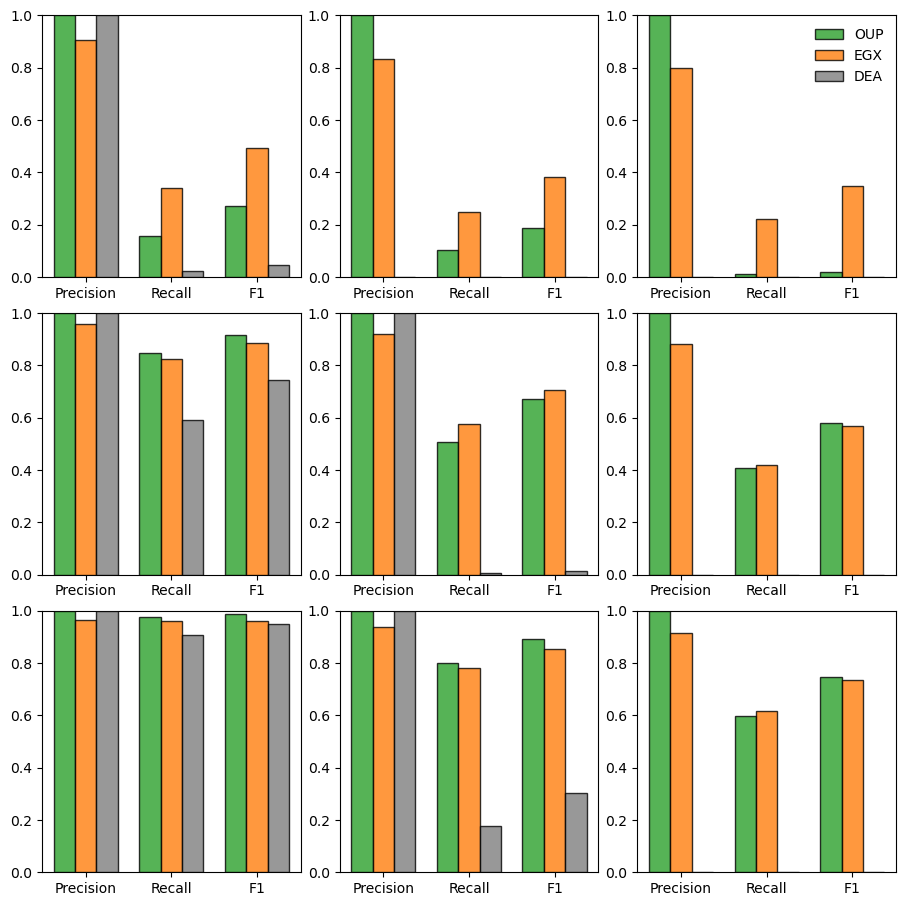

In [ ]:
rs = [0.5, 0.2, 0.1]
thetas = [1, 2, 3]

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i in range(len(rs)):
    for j in range(len(thetas)):
        n = 0
        for a in [3]:
            for s in [1]:
                OUP_neg = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0_chi-squared.tsv"
                OUP_pos = f"./500_NB{rs[i]}_a{a}_s{s}/OUNB_root0-{thetas[j]}_chi-squared.tsv"
                DEA_neg = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0.tsv"
                DEA_pos = f"./500_NB{rs[i]}_a{a}_s{s}/DEA_readcounts_root0-{thetas[j]}.tsv"
                EGX_neg = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0_long.csv"
                EGX_pos = f"./500_NB{rs[i]}_a{a}_s{s}/EGX_readcounts_root0-{thetas[j]}_long.csv"
                plot_f1(axes[j, i], f"a{a}_s{s}", OUP_neg, OUP_pos, DEA_neg, DEA_pos, EGX_neg, EGX_pos)
                n += 1
                
axes[0, -1].legend(frameon=False, loc="upper right")
plt.tight_layout(pad=0.5)
plt.savefig(f"./a{a}_s{s}_score.png", dpi=300, bbox_inches="tight")
plt.show(fig)